<h1 style="text-align:center">Analysis of Chinese Gum Rosin Exp/Imp Prices and Volumes</h1>
<h3 style="text-align:center">TIME SERIES PREDICTION ANALYSIS</h3>
<br>
<h3 style="text-align:center"><i>Sources: Data:  1995 - 2017  China.cn / Data 2018 - 2020 Penta Transactions / Data: 2021 Rosineb.com</i></h3>
<br>
<br>

<p>First we start setting up the scenario by importing some Python packages to this Jupyter Notebook...</p>

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
import numpy as np
import warnings
import itertools
import datetime
import missingno as msno
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import Image
from IPython.core.display import HTML 

from pylab import rcParams
import statsmodels.api as sm
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.stattools import adfuller

# Ignore the warning, can comment this 
warnings.filterwarnings("ignore")

# For graphing purpose, can change 
plt.style.use('bmh')
matplotlib.rcParams['axes.labelsize'] = 20
matplotlib.rcParams['xtick.labelsize'] = 16
matplotlib.rcParams['ytick.labelsize'] = 16
matplotlib.rcParams['text.color'] = 'k'
matplotlib.rcParams['axes.labelcolor'] = 'r'
matplotlib.rcParams['xtick.color'] = 'r'
matplotlib.rcParams['ytick.color'] = 'r'

<br>
<br>
<h1 style="text-align:center">INDEX</h1>
<br>
<table>
<tbody>
<tr><td><h3>1.- Uploading data from Excel file.</h3></td></tr>  
<tr><td><h3>2.- Visualizing the data.</h3></td></tr>
<tr><td><h3>3.- Decomposing the data.</h3></td></tr>   
<tr><td><h3>4.- Visualization: Graphing the rolling statistics for testing stationarity.</h3></td></tr>  
<tr><td><h4>4.1.- Augmented Dickey-Fuller Test.</h4></td></tr>
<tr><td><h4>4.2.- Detrending.</h4></td></tr>
<tr><td><h4>4.3.- Differencing.</h4></td></tr>
<tr><td><h4>4.4.- Detrending + Differencing.</h4></td></tr>
<tr><td><h3>5.- Set the y_to_train, y_to_test, and the length of predict units.</h3></td></tr>      
<tr><td><h3>6.- Different time series prediction models.</h3></td></tr>
<tr><td><h4>6.1.- Simple exponential smothing.</h4></td></tr>
<tr><td><h4>6.2.- Holt.</h4></td></tr>
<tr><td><h4>6.3.- Holt-Winters.</h4></td></tr>
<tr><td><h4>6.4.- SARIMA.</h4></td></tr>
<tr><td><h3>6.- Reference material.</h3></td></tr>
</tbody>
</table>
<br>
<br>

<p>Let's talk first of the data available before starting the time series prediction (TSP) analysis. We have been collection custom import/export data since 1995 for chinese pine chemicals and hydrocarbon resins. The source between 1955 to 2017 was <a href="https://chem.cn">Chem.cn</a>, and between 2018 and 2020 was <a href="https://app.penta-transaction.com/login">Penta Transactions</a>. For the most recent data we use <a href="https://rosineb.com/eng">Rosineb</a>, usually the last data point available is two month old.</p>
<p>We are going to start this analysis with Chinese GUM ROSIN (HS Code 3806.10.10) import and export data. The two graphs below show the information available in our data base, telling two different stories. One before 2012 and the other after 2012. The top graph shows clearly the cyclic export volume of GUM ROSIN from China to Europe, pushed by European free duties import quotas, and extremly low volume of imports. Around 2012 the situation changes drastically, because of the expiration of European duty free import quotas, and a slow but steady decline in Chinese GUM ROSIN production.</p>
<p>We can observe in 2006 a month when more than 50.000 metric tons where exported from China in one month, and also that in 2017 the balance between export and imports was almost zero. In the last quarter of 2020 more than 10.000 metric tons of GUM ROSIN where imported from different origins, showing a totally oposite situation. This analysis will try to figure out future scenarios for China import/exports of GUM ROSIN.</p>
<img src="img/20211117_170316.png" width=1000 height=600 />
<p>The price graph for Chinese GUM ROSIN import and exports </p>
<img src="img/20211117_170335.png" width=1000 height=600 />

<br>
<br>
<h1 style="text-align:center">1.- Uploading data from Excel file.</h1>

In [3]:
# Time Series Prediction parameters
Excel_file = 'Excel/20211115_apc_INST_Stats-CH-ExpImp.xlsx'
Excel_sheet = '38061010'

Index = 'month'
Index_lable = 'Monthly'

imp_usd = 'imp_usd'
imp_kg = 'imp_kg'
exp_usd = 'exp_usd'
exp_kg = 'exp_kg'

Date_start = '2012-01-01'
Date_end = '2021-09-01'
Month_to_test = '2021-03-01'

Resample = 'Q' # 'W' = weekly, 'M' = monthtly; 'Q' = quarterly; 'Y' = yearly
Resample_lable = 'Quarterly Mean Resample'


In [4]:
# Import the data
df = pd.read_excel(Excel_file, sheet_name=Excel_sheet)
df[Index] = pd.to_datetime(df[Index])
# Set the month as index 
df = df.set_index(Index)
# Select the proper time period for quarterly aggreagation
df = df[Date_start:Date_end]
dfq = df[Date_start:Date_end].resample(Resample).sum()
# Explore content of monthly dataframe
display(df)
df.info()

,country,trade,hs_code,exp_usd,exp_kg,exp_usd-ton,imp_usd,imp_kg,imp_usd-ton,source,Unnamed: 11,Unnamed: 12,Unnamed: 13
month,,,,,,,,,,,,,
2012-01-01,CHINA,IMP,3806.10.10,21972889.0,13804984.0,1591.663489,392418.0,138063.0,2842.311119,CHEM.CN,NaN,NaN,NaN
2012-02-01,CHINA,IMP,3806.10.10,22761717.0,13575276.0,1676.703811,747210.0,350467.0,2132.040962,CHEM.CN,NaN,NaN,NaN
2012-03-01,CHINA,IMP,3806.10.10,22193067.0,13485896.0,1645.650167,1673792.0,1043279.0,1604.357032,CHEM.CN,NaN,NaN,NaN
2012-04-01,CHINA,IMP,3806.10.10,23909804.0,14095103.0,1696.319920,2842253.0,1593324.0,1783.851244,CHEM.CN,NaN,NaN,NaN
2012-05-01,CHINA,IMP,3806.10.10,17040462.0,10066529.0,1692.784275,630937.0,239689.0,2632.315208,CHEM.CN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-01,CHINA,IMP,3806.10.10,4543528.0,1838850.0,2470.852979,14353253.0,9213880.0,1557.785971,ROSINEB,NaN,NaN,NaN
2021-06-01,CHINA,IMP,3806.10.10,4098514.0,1646580.0,2489.107119,13295284.0,8266430.0,1608.346529,ROSINEB,NaN,NaN,NaN
2021-07-01,CHINA,IMP,3806.10.10,4503560.0,1903520.0,2365.911574,10982922.0,6802280.0,1614.594224,ROSINEB,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 117 entries, 2012-01-01 to 2021-09-01
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   country      117 non-null    object 
 1   trade        117 non-null    object 
 2   hs_code      117 non-null    object 
 3   exp_usd      117 non-null    float64
 4   exp_kg       117 non-null    float64
 5   exp_usd-ton  117 non-null    float64
 6   imp_usd      117 non-null    float64
 7   imp_kg       117 non-null    float64
 8   imp_usd-ton  117 non-null    float64
 9   source       117 non-null    object 
 10  Unnamed: 11  0 non-null      float64
 11  Unnamed: 12  0 non-null      float64
 12  Unnamed: 13  0 non-null      float64
dtypes: float64(9), object(4)
memory usage: 16.9+ KB


<AxesSubplot:>

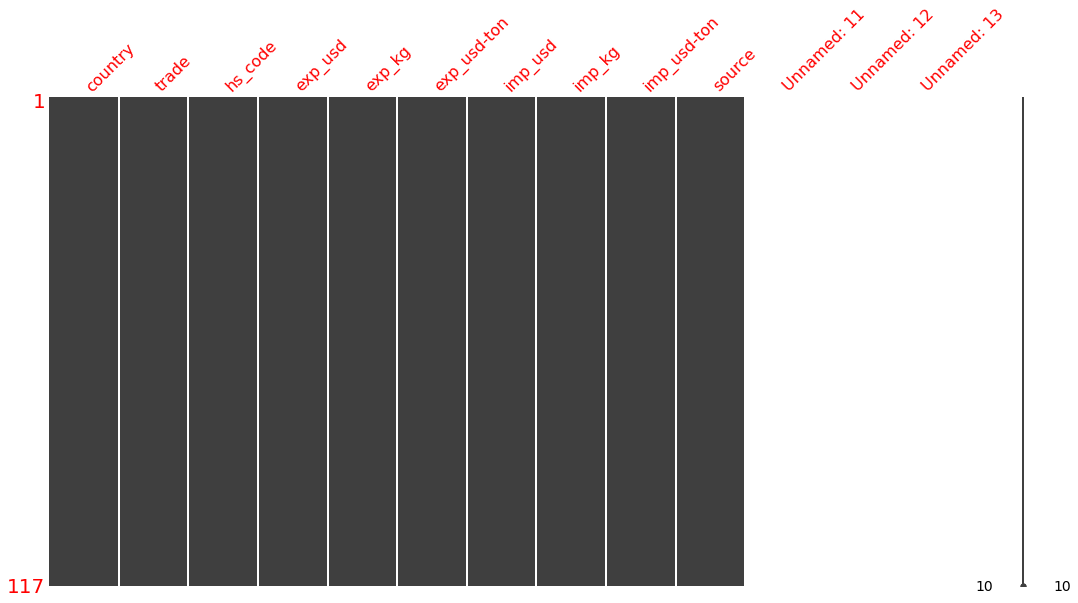

In [5]:
# Chart missing data
msno.matrix(df, figsize=(18,9))

In [6]:
# Explore content of quarterly dataframe
display(dfq)
dfq.info()

,exp_usd,exp_kg,exp_usd-ton,imp_usd,imp_kg,imp_usd-ton,Unnamed: 11,Unnamed: 12,Unnamed: 13
month,,,,,,,,,
2012-03-31,66927673.0,40866156.0,4914.017466,2813420.0,1531809.0,6578.709113,0.0,0.0,0.0
2012-06-30,62941948.0,37317428.0,5060.738660,3892694.0,1866217.0,17050.306918,0.0,0.0,0.0
2012-09-30,67013878.0,44152227.0,4566.765696,4354043.0,2493348.0,6172.908418,0.0,0.0,0.0
2012-12-31,71198754.0,45384790.0,4657.820326,6487717.0,4027089.0,5147.820986,0.0,0.0,0.0
2013-03-31,48587130.0,28302419.0,5154.689540,9387439.0,6181287.0,4575.587699,0.0,0.0,0.0
2013-06-30,55763968.0,31485299.0,5318.730633,10744372.0,7326729.0,4415.640741,0.0,0.0,0.0
2013-09-30,61655499.0,30929579.0,5873.425926,14217740.0,9673180.0,4408.725527,0.0,0.0,0.0
2013-12-31,106209461.0,42419197.0,7489.663500,13266008.0,7232035.0,5548.689569,0.0,0.0,0.0
2014-03-31,74869829.0,29590314.0,7607.172959,9156222.0,4238626.0,6506.670350,0.0,0.0,0.0


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 39 entries, 2012-03-31 to 2021-09-30
Freq: Q-DEC
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   exp_usd      39 non-null     float64
 1   exp_kg       39 non-null     float64
 2   exp_usd-ton  39 non-null     float64
 3   imp_usd      39 non-null     float64
 4   imp_kg       39 non-null     float64
 5   imp_usd-ton  39 non-null     float64
 6   Unnamed: 11  39 non-null     float64
 7   Unnamed: 12  39 non-null     float64
 8   Unnamed: 13  39 non-null     float64
dtypes: float64(9)
memory usage: 3.0 KB


<br>
<br>
<h1 style="text-align:center">2.- Visualizing the data.</h1>

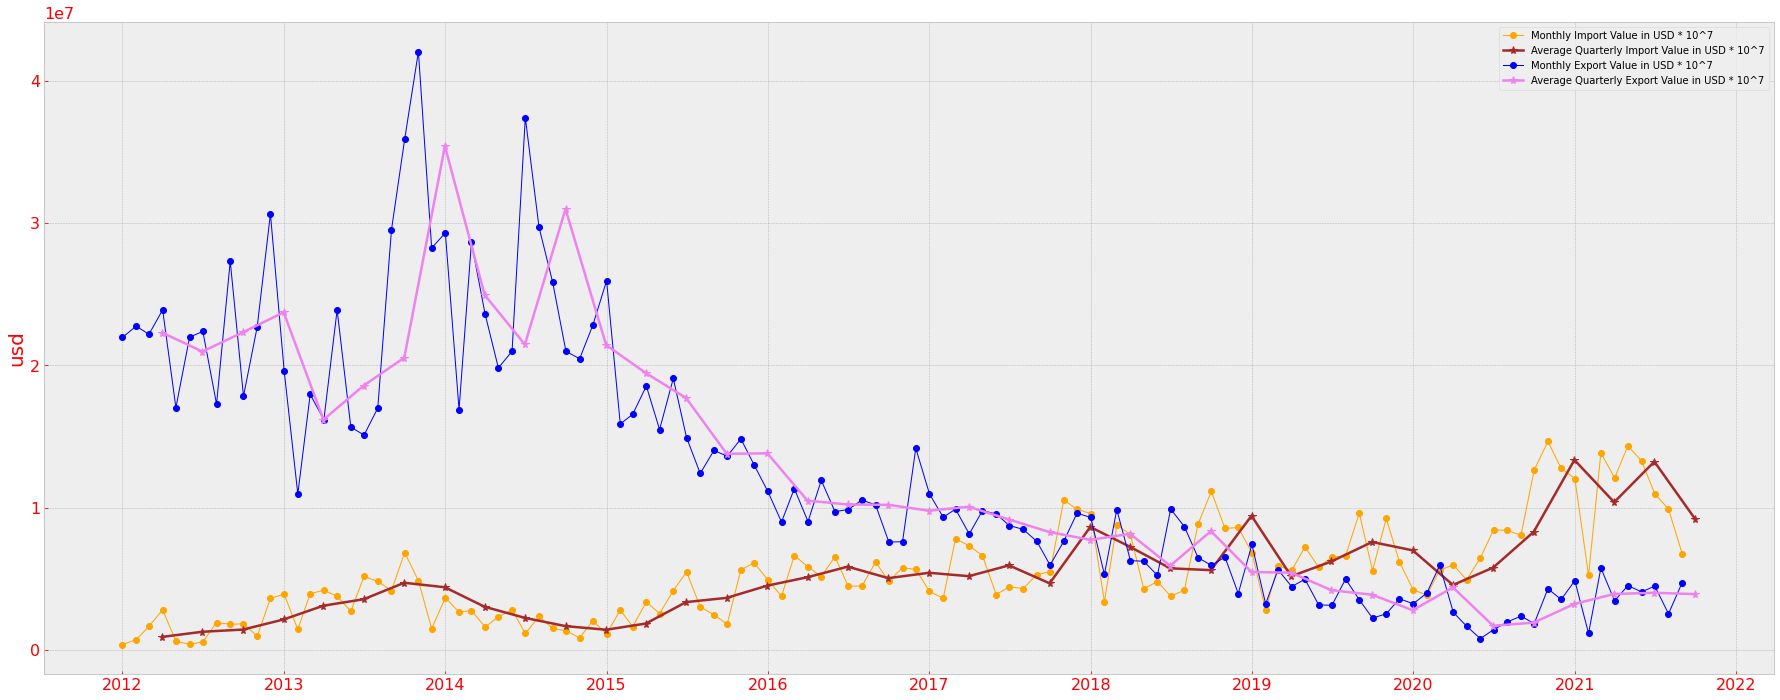

In [7]:
# Charting import vs. export value data
y1 = df[imp_usd]
y2 = df[exp_usd]
fig, ax = plt.subplots(figsize=(31, 12))
ax.plot(y1,marker='o', color='orange', linestyle='-', linewidth=1, label='Monthly Import Value in USD * 10^7')
ax.plot(y1.resample('Q').mean(), marker='*', markersize=8, color='brown', linestyle='-', linewidth=2.5, label='Average Quarterly Import Value in USD * 10^7')
ax.plot(y2,marker='o', color='blue', linestyle='-', linewidth=1, label='Monthly Export Value in USD * 10^7')
ax.plot(y2.resample('Q').mean(), marker='*', markersize=8, color='violet', linestyle='-', linewidth=2.5, label='Average Quarterly Export Value in USD * 10^7')
ax.set_ylabel('usd')
ax.legend();

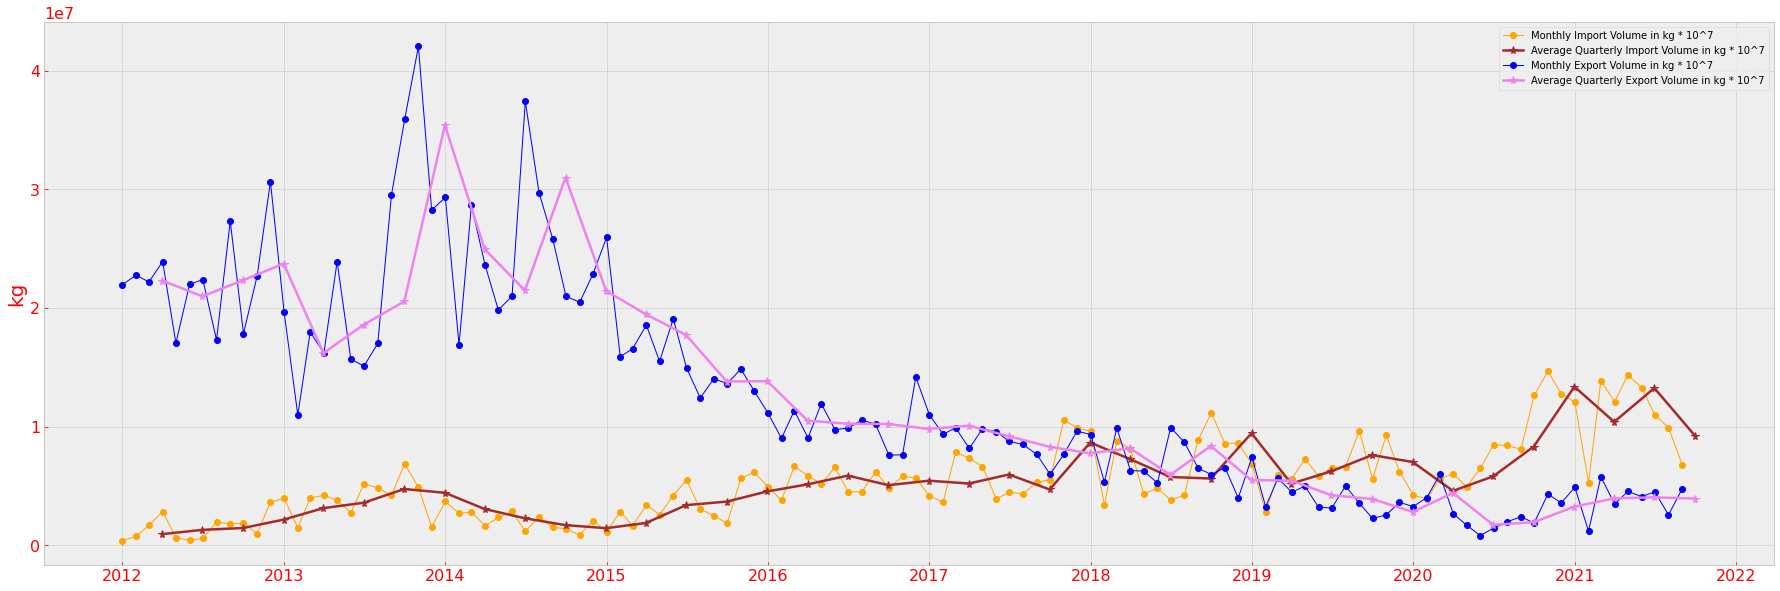

In [8]:
# Charting import vs. export volume data
y3 = df[imp_kg]
y4 = df[exp_kg]
fig, ax = plt.subplots(figsize=(31, 10))
ax.plot(y1,marker='o', color='orange', linestyle='-', linewidth=1, label='Monthly Import Volume in kg * 10^7')
ax.plot(y1.resample('Q').mean(), marker='*', markersize=8, color='brown', linestyle='-', linewidth=2.5, label='Average Quarterly Import Volume in kg * 10^7')
ax.plot(y2,marker='o', color='blue', linestyle='-', linewidth=1, label='Monthly Export Volume in kg * 10^7')
ax.plot(y2.resample('Q').mean(), marker='*', markersize=8, color='violet', linestyle='-', linewidth=2.5, label='Average Quarterly Export Volume in kg * 10^7')
ax.set_ylabel('kg')
ax.legend();

<br>
<br>
<h1 style="text-align:center">3.- Decomposing the data.</h1>

Additive decomposition: y(t) = Level + Trend + Seasonality + Noise <br>
Multiplicative decomposition: y(t) = Level * Trend * Seasonality * Noise <br><br>
<a href="https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/">How to Decompose Time Series Data into Trend and Seasonality</a>

<br>
<br>
<h2 style="text-align:center">3.1.- Additive decomposing.</h2>

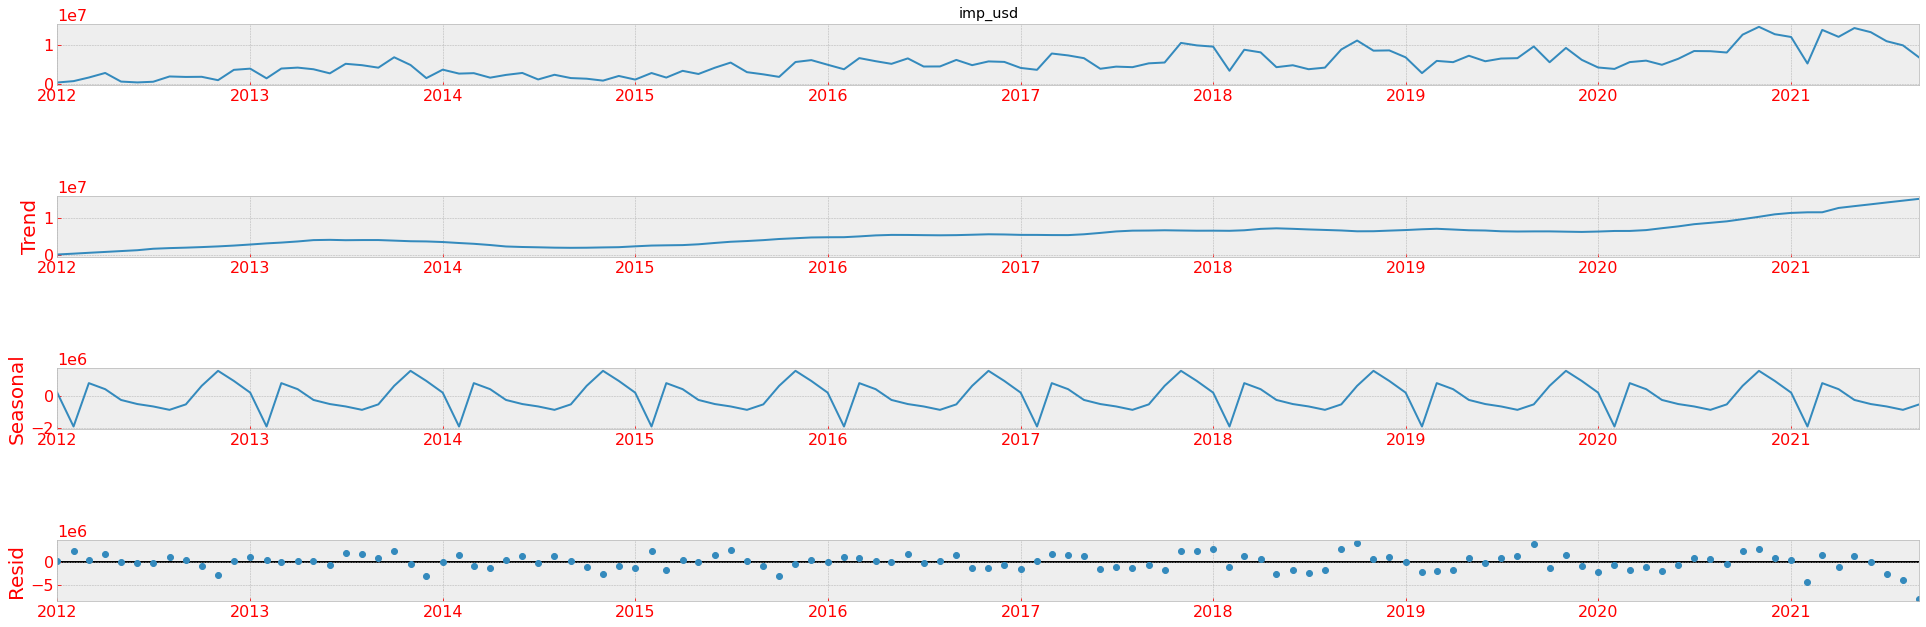

In [13]:
# graphs to show seasonal_decompose
def seasonal_decompose_add (y1):
    decomposition = sm.tsa.seasonal_decompose(y1, model='additive',extrapolate_trend='freq')
    fig = decomposition.plot()
    fig.set_size_inches(31,10)
    plt.show()
    
seasonal_decompose_add(y1)    

<br>
<br>
<h2 style="text-align:center">3.2.- Multiplicative decomposing.</h2>

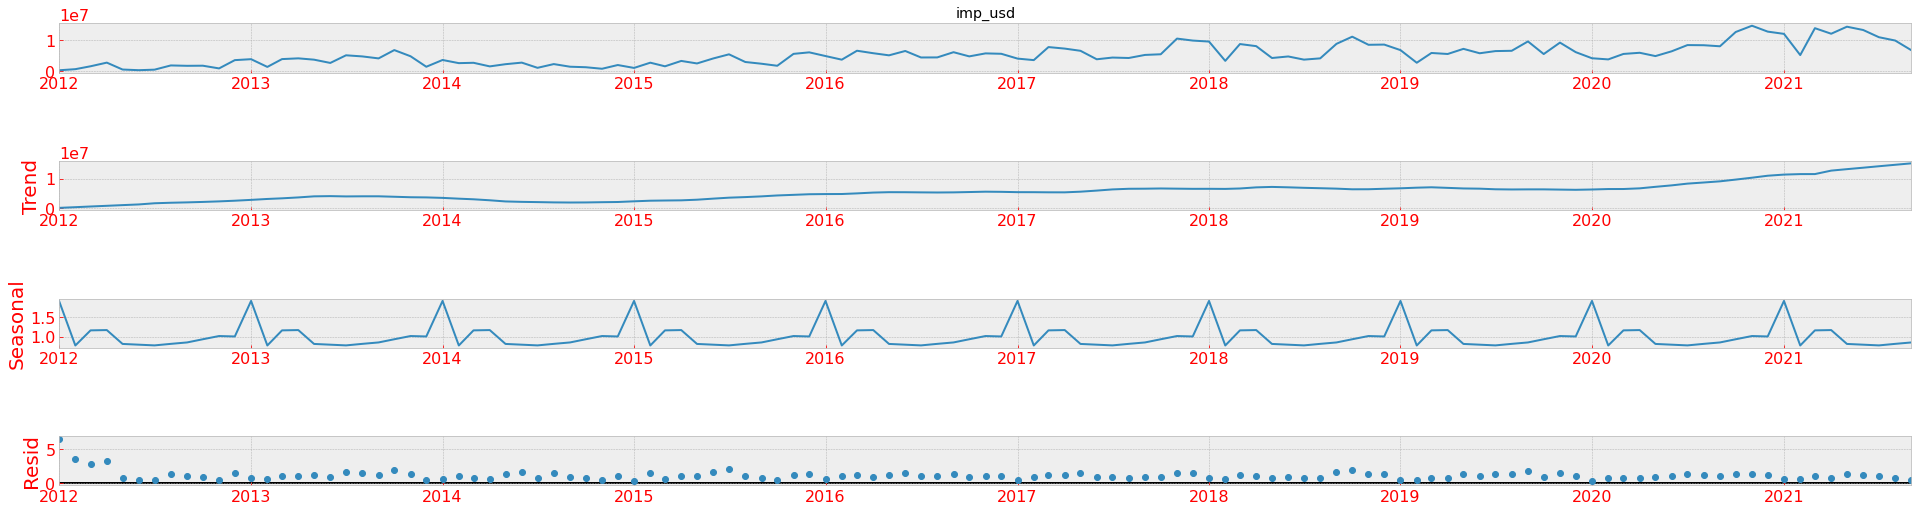

In [14]:
# graphs to show seasonal_decompose
def seasonal_decompose_mult (y1):
    decomposition = sm.tsa.seasonal_decompose(y1, model='multiplicative',extrapolate_trend='freq')
    fig = decomposition.plot()
    fig.set_size_inches(31,8)
    plt.show()
    
seasonal_decompose_mult(y1)    

<br>
<br>
<h1 style="text-align:center">4.- Visualization: Graphing the rolling statistics for testing stationarity.</h1>

In [ ]:
# Plot for Rolling Statistic for testing Stationarity
def test_stationarity(timeseries, title):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=12).mean() 
    rolstd = pd.Series(timeseries).rolling(window=12).std()
    
    fig, ax = plt.subplots(figsize=(31, 8))
    ax.plot(timeseries, color='red', label= title)
    ax.plot(rolmean, color='black', label='rolling mean');
    ax.plot(rolstd, color='blue', label='rolling std (x10)');
    ax.legend()
    

In [ ]:
pd.options.display.float_format = '{:.8f}'.format
test_stationarity(y,'raw data')

<br>
<br>
<h2 style="text-align:center">4.1.- Augmented Dickey-Fuller Test.</h2>

In [ ]:
# Augmented Dickey-Fuller Test
from statsmodels.tsa.stattools import adfuller

def ADF_test(timeseries, dataDesc):
    print(' > Is the {} stationary ?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))


In [ ]:
ADF_test(y,'raw data')

<br>
<br>
<h2 style="text-align:center">4.2.- Augmented Dickey-Fuller Test.</h2>

In [ ]:
# Detrending
y_detrend =  (y - y.rolling(window=24).mean())/y.rolling(window=24).std()

test_stationarity(y_detrend,'de-trended data')
ADF_test(y_detrend,'de-trended data')

<br>
<br>
<h2 style="text-align:center">4.3.- Augmented Dickey-Fuller Test.</h2>

In [ ]:
# Differencing
y_24lag =  y - y.shift(24)

test_stationarity(y_24lag,'24 lag differenced data')
ADF_test(y_24lag,'24 lag differenced data')

<br>
<br>
<h2 style="text-align:center">4.4.- Detrending + Differencing.</h2>

In [ ]:
# Detrending + Differencing

y_24lag_detrend =  y_detrend - y_detrend.shift(24)

test_stationarity(y_24lag_detrend,'24 lag differenced de-trended data')
ADF_test(y_24lag_detrend,'24 lag differenced de-trended data')

<br>
<br>
<h1 style="text-align:center">5.- Set the y_to_train, y_to_test, and the length of predict units .</h1>

In [ ]:
y_to_train = y[Date_start:Month_to_test] # dataset to train
y_to_val = y[Month_to_test:]             # last X months for test  
predict_date = 24                        #len(y) - len(y[:Month_to_test]) # the number of data points for the test setp
print(predict_date)

<br>
<br>
<h1 style="text-align:center">6.- Different time series prediction models.</h1>

<br>
<br>
<h2 style="text-align:center">6.1.- Simple exponential smothing.</h2>

In [ ]:
import numpy as np
from statsmodels.tsa.api import SimpleExpSmoothing 

def ses(y, y_to_train,y_to_test,smoothing_level,predict_date):
    y.plot(marker='o', color='red', legend=True, figsize=(31, 8))
    
    fit1 = SimpleExpSmoothing(y_to_train).fit(smoothing_level=smoothing_level,optimized=False)
    fcast1 = fit1.forecast(predict_date).rename(r'$\alpha={}$'.format(smoothing_level))
    # specific smoothing level
    fcast1.plot(marker='*', color='blue', legend=True)
    fit1.fittedvalues.plot(marker='*',  color='blue')
    mse1 = ((fcast1 - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of our forecasts with smoothing level of {} is {}'.format(smoothing_level,round(np.sqrt(mse1), 2)))
    
    ## auto optimization
    fit2 = SimpleExpSmoothing(y_to_train).fit()
    fcast2 = fit2.forecast(predict_date).rename(r'$\alpha=%s$'%fit2.model.params['smoothing_level'])
    fcast2.plot(marker='*', color='green', legend=True)
    fit2.fittedvalues.plot(marker='*', color='green')
    
    mse2 = ((fcast2 - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of our forecasts with auto optimization is {}'.format(round(np.sqrt(mse2), 2)))
    
    plt.show()
    

In [ ]:
ses(y, y_to_train, y_to_val, 0.8, predict_date)

<br>
<br>
<h2 style="text-align:center">6.2.- Holt.</h2>

In [ ]:
from statsmodels.tsa.api import Holt

def holt(y,y_to_train,y_to_test,smoothing_level,smoothing_slope, predict_date):
    y.plot(marker='o', color='red', legend=True, figsize=(31, 8))
    
    fit1 = Holt(y_to_train).fit(smoothing_level, smoothing_slope, optimized=False)
    fcast1 = fit1.forecast(predict_date).rename("Holt's linear trend")
    mse1 = ((fcast1 - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of Holt''s Linear trend {}'.format(round(np.sqrt(mse1), 2)))

    fit2 = Holt(y_to_train, exponential=True).fit(smoothing_level, smoothing_slope, optimized=False)
    fcast2 = fit2.forecast(predict_date).rename("Exponential trend")
    mse2 = ((fcast2 - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of Holt''s Exponential trend {}'.format(round(np.sqrt(mse2), 2)))
    
    fit1.fittedvalues.plot(marker="*", color='blue')
    fcast1.plot(color='blue', marker="*", legend=True)
    fit2.fittedvalues.plot(marker="*", color='green')
    fcast2.plot(color='red', marker="*", legend=True)

    plt.show()

In [ ]:
holt(y, y_to_train,y_to_val,0.6,0.2,predict_date)

<br>
<br>
<h2 style="text-align:center">6.3.- Holt-Winters.</h2>

In [ ]:
from statsmodels.tsa.api import ExponentialSmoothing

def holt_win_sea(y,y_to_train,y_to_test,seasonal_type,seasonal_period,predict_date):
    
    y.plot(marker='o', color='red', legend=True, figsize=(31, 8))
    
    if seasonal_type == 'additive':
        fit1 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='add').fit(use_boxcox=True)
        fcast1 = fit1.forecast(predict_date).rename('Additive')
        mse1 = ((fcast1 - y_to_test) ** 2).mean()
        print('The Root Mean Squared Error of additive trend, additive seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse1), 2)))
        
        fit2 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='add', damped=True).fit(use_boxcox=True)
        fcast2 = fit2.forecast(predict_date).rename('Additive+damped')
        mse2 = ((fcast2 - y_to_test) ** 2).mean()
        print('The Root Mean Squared Error of additive damped trend, additive seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse2), 2)))
        
        fit1.fittedvalues.plot(style='--', color='blue')
        fcast1.plot(style='--', marker='*', color='blue', legend=True)
        fit2.fittedvalues.plot(style='--', color='green')
        fcast2.plot(style='--', marker='*', color='green', legend=True)
    
    elif seasonal_type == 'multiplicative':  
        fit3 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='mul').fit(use_boxcox=True)
        fcast3 = fit3.forecast(predict_date).rename('Multiplicative')
        mse3 = ((fcast3 - y_to_test) ** 2).mean()
        print('The Root Mean Squared Error of additive trend, multiplicative seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse3), 2)))
        
        fit4 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='mul', damped=True).fit(use_boxcox=True)
        fcast4 = fit4.forecast(predict_date).rename('Multiplicative+damped')
        mse4 = ((fcast3 - y_to_test) ** 2).mean()
        print('The Root Mean Squared Error of additive damped trend, multiplicative seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse4), 2)))
        
        fit3.fittedvalues.plot(style='--', color='blue')
        fcast3.plot(style='--', marker='*', color='blue', legend=True)
        fit4.fittedvalues.plot(style='--', color='green')
        fcast4.plot(style='--', marker='*', color='green', legend=True)
        
    else:
        print('Wrong Seasonal Type. Please choose between additive and multiplicative')

    plt.show()


In [ ]:
holt_win_sea(y, y_to_train,y_to_val,'additive',24, predict_date)

<br>
<br>
<h2 style="text-align:center">6.4.- SARIMA.</h2>

<img src="img/20211117_070254.png" width=1000 height=600 />
<a href="https://github.com/alexcunn/Time-Series-Prediction">GitHub: Vera Shao / Bounteous - Time Series Prediction</a>

In [ ]:
import itertools

def sarima_grid_search(y,seasonal_period):
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2],seasonal_period) for x in list(itertools.product(p, d, q))]
    
    mini = float('+inf')
    
    
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(y,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                results = mod.fit()
                
                if results.aic < mini:
                    mini = results.aic
                    param_mini = param
                    param_seasonal_mini = param_seasonal

#                 print('SARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            except:
                continue
    print('The set of parameters with the minimum AIC is: SARIMA{}x{} - AIC:{}'.format(param_mini, param_seasonal_mini, mini))


In [ ]:
sarima_grid_search(y,24)

In [ ]:
# Call this function after pick the right(p,d,q) for SARIMA based on AIC               
def sarima_eva(y,order,seasonal_order,seasonal_period,pred_date,y_to_test):
    # fit the model 
    mod = sm.tsa.statespace.SARIMAX(y,
                                order=order,
                                seasonal_order=seasonal_order,
                                enforce_stationarity=False,
                                enforce_invertibility=False)

    results = mod.fit()
    print(results.summary().tables[1])
    
    results.plot_diagnostics(figsize=(31, 8))
    plt.show()
    
    # The dynamic=False argument ensures that we produce one-step ahead forecasts, 
    # meaning that forecasts at each point are generated using the full history up to that point.
    pred = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=False)
    pred_ci = pred.conf_int()
    y_forecasted = pred.predicted_mean
    mse = ((y_forecasted - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of SARIMA with season_length={} and dynamic = False {}'.format(seasonal_period,round(np.sqrt(mse), 2)))

    ax = y.plot(label='observed')
    y_forecasted.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Sessions')
    plt.legend()
    plt.show()

    # A better representation of our true predictive power can be obtained using dynamic forecasts. 
    # In this case, we only use information from the time series up to a certain point, 
    # and after that, forecasts are generated using values from previous forecasted time points.
    pred_dynamic = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=True, full_results=True)
    pred_dynamic_ci = pred_dynamic.conf_int()
    y_forecasted_dynamic = pred_dynamic.predicted_mean
    mse_dynamic = ((y_forecasted_dynamic - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of SARIMA with season_length={} and dynamic = True {}'.format(seasonal_period,round(np.sqrt(mse_dynamic), 2)))

    ax = y.plot(label='observed')
    y_forecasted_dynamic.plot(label='Dynamic Forecast', ax=ax,figsize=(14, 7))
    ax.fill_between(pred_dynamic_ci.index,
                    pred_dynamic_ci.iloc[:, 0],
                    pred_dynamic_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Sessions')

    plt.legend()
    plt.show()
    
    return (results)

In [ ]:
sarima_date = datetime.datetime(2020, 12, 1)

In [ ]:
model = sarima_eva(y,(1, 1, 1),(1, 1, 0, 24),24,sarima_date,y_to_val)

In [ ]:
def forecast(model,predict_steps,y):
    
    pred_uc = model.get_forecast(steps=predict_steps)

    #SARIMAXResults.conf_int, can change alpha,the default alpha = .05 returns a 95% confidence interval.
    pred_ci = pred_uc.conf_int()

    ax = y.plot(label='observed', figsize=(31, 8))
#     print(pred_uc.predicted_mean)
    pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.25)
    ax.set_xlabel('Date')
    ax.set_ylabel(y.name)

    plt.legend()
    plt.show()
    
    # Produce the forcasted tables 
    pm = pred_uc.predicted_mean.reset_index()
    pm.columns = ['Date','Predicted_Mean']
    pci = pred_ci.reset_index()
    pci.columns = ['Date','Lower Bound','Upper Bound']
    final_table = pm.join(pci.set_index('Date'), on='Date')
    
    return (final_table)

In [ ]:
final_table = forecast(model,12,y)
final_table.head()

In [ ]:
### Graphs without the confident interval 
pred_uc = model.get_forecast(steps=51)
ax = y.plot(label='observed', figsize=(31, 8))
#     print(pred_uc.predicted_mean)
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.set_xlabel('Date')
ax.set_ylabel(y.name)

plt.legend()
plt.show()

In [ ]:
### Graphs show only the perdiected period
final_table.index = final_table.Date
fig, ax = plt.subplots( figsize=(31, 8))
# ax.plot(y,marker='.', linestyle='-', linewidth=0.5, label='Weekly')
ax.plot(final_table.Predicted_Mean,marker='.', linestyle='-', linewidth=0.5, label='Predicted Weekly')
# ax.plot(y.resample('M').mean(),marker='o', markersize=8, linestyle='-', label='Monthly Mean Resample')
ax.plot(final_table.Predicted_Mean.resample('M').mean(),marker='o', markersize=8, linestyle='-', label='Predicted Monthly Mean Resample')
ax.set_ylabel('imp+usd')
ax.legend();

<br>
<br>
<h1 style="text-align:center">7.- Reference Material</h1>
<br>
<table>
<tbody>
<tr><td><h3>1. Good overall & recap of time series prediction slides: <a href="http://people.cs.pitt.edu/~milos/courses/cs3750/lectures/class16.pdf">GitHub - Vera Shao / Bounteous - Time Series Prediction.</a></h3></td></tr>  
<tr><td><h3>2. Checking Stationarity help source: <a href="https://towardsdatascience.com/time-series-in-python-exponential-smoothing-and-arima-processes-2c67f2a52788">Time series in Python exponential smooting and ARIMA processes.</a></h3></td></tr>
</tbody>
<tr><td><h3>3. Simple Exponential Smoothing help source: <a href="https://medium.com/datadriveninvestor/how-to-build-exponential-smoothing-models-using-python-simple-exponential-smoothing-holt-and-da371189e1a1">How to build exponential smoothing models using Python: Simple Exponential Smoothing, Holt, and Holt-Winters.</a></h3></td></tr>
<tr><td><h3>4. SARIMA help sources: <a href="https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3">Time series in Python exponential smooting and ARIMA processes.</a></h3></td></tr>
<tr><td><h3>5. asdf: <a href="https://asdf/">asdf.</a></h3></td></tr>
<tr><td><h3>6. Article to use Fourier terms: <a href="https://medium.com/intive-developers/forecasting-time-series-with-multiple-seasonalities-using-tbats-in-python-398a00ac0e8a">Forecasting series with multiple seasonalities using tbats in Python.</a></h3></td></tr>
</tbody>
</tbody>
</tbody>
</tbody>    
</table>
<br>
<br>